In [97]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd

### Calcul de la mensualité:

$m$ = mensualité

$N$ = Durée du prêt (en années)

$\alpha$ = Taux d'intéret annuel

$C$ = montant du prêt


Au mois $n$, le restant à payer $C_n$ vaut: $C_n = C_{n-1} + \frac{\alpha}{12}C_{n-1}-m = \left(1+\frac{\alpha}{12}\right)C_{n-1}-m$

On reconnaît une suite arithmético-géométrique de terme général: $C_n = \left(1+\frac{\alpha}{12}\right)^n\left(C-\frac{12m}{\alpha}\right)+\frac{12m}\alpha$

Donc à l'année $N$, le restant à payer (qui doit être nul) vaut: $\left(1+\frac{\alpha}{12}\right)^{12N}\left(C-\frac{12m}{\alpha}\right)+\frac{12m}\alpha$. On obtient:

\begin{align}
m = \frac{\frac{\alpha C}{12}}{1-\left(1+\frac{\alpha}{12}\right)^{-12N}}
\end{align}

In [98]:
def mensualité(alpha, C, N):
    return alpha*C/12/(1-(1+alpha/12)**(-12*N))

def c(n, alpha, C, N):
    m = mensualité(alpha, C, N)
    if n <= 12*N:
        return (1+alpha/12)**n*(C-12*m/alpha)+12*m/alpha
    else:
        return 0

### Calcul du rendement au mois $n$ < $12N$

$\mu$ = croissance annuelle du bien immobilier

$l$ = loyer

$f_n$ = frais de notaire

$f_g$ = frais de gestion locative (en % du loyer)

$A$ = Apport

$p$ = prélèvements sociaux

$i$ = impôts

Au bout du mois $n$, le propriétaire possède:
- Le bien immobilier d'une valeur $(1+\mu)^{\frac{n}{12}}C$
- Le cumul des loyers s'élevant à hauteur de $nl$ (dont il faut déduire les impôts)

Il a dépensé $nm$ en mensualité, $nf_gl$ en frais de gestion locative, $f+A$ en apport total, et est endetté à hauteur de $C_n$

Son rendement au mois $n$ s'élève donc à:

\begin{align}
\eta = \frac{n(l(1-i)-m-f_gl)+\left(1+\mu\right)^\frac{n}{12}C-C_n-(f_n+A)}{f_n+A}
\end{align}

In [99]:
def rendement(n, l, alpha, C, N, mu, fn, A, fg, i):
    m = mensualité(alpha, C, N)
    Cn = c(n, alpha, C, N)
    if n <= 12*N: # On généralise la formule après avori remboursé la totalité du prêt
        return((n*(l*(1-i)-m-fg*l)+C*(1+mu)**(n/12)-Cn-(fn+A))/(fn+A))
    else:
        return((n*(l*(1-i)-fg*l)-12*N*m+C*(1+mu)**(n/12)-Cn-(fn+A))/(fn+A))

### Simulation: étude du rendement d'un investissement immobilier vs. en bourse

289.9798589915459


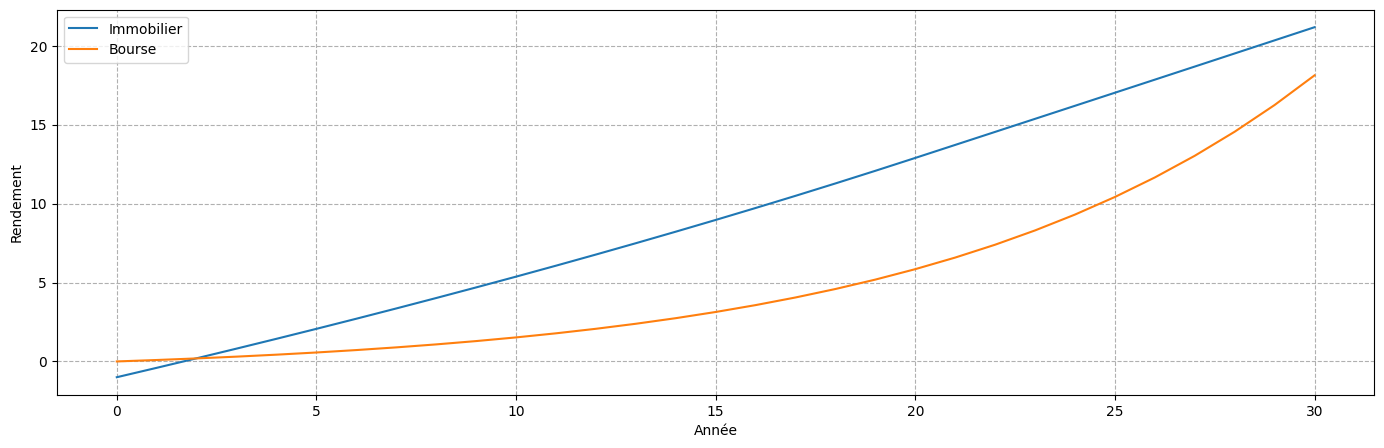

In [100]:
alpha = 3.5/100 # Taux du prêt
N = 20 # Durée totale du prêt
mu = 1/100 # Croissance de la valeur du bien immobilier
C = 50000 # Montant du montant emprunté
l = 630 # Loyer
fn = 8000 # Frais de notaire et d'agence
A = 0 # 10/100*C # Apport
fg = 8/100 # Coûts de gestion locative (en % du loyer)
i = 12.8/100 # impôts sur le revenu

beta = 11/100 # Performance de la bourse
p = 17.2/100 # Prélèvements sociaux

m = mensualité(alpha, C, N) ; print(m)

List_n = range(0, 31)
List_rendement_immo = []
List_rendement_bourse = []

for n in List_n:
    List_rendement_immo.append(rendement(12*n, l, alpha, C, N, mu, fn, A, fg, i))
    List_rendement_bourse.append(((1+beta)**n-1)*(1-p))

plt.figure(figsize=(17, 5))
plt.plot(List_n, List_rendement_immo, label='Immobilier')
plt.plot(List_n, List_rendement_bourse, label='Bourse')
plt.xlabel('Année')
plt.ylabel('Rendement')
plt.grid(linestyle='--')
plt.legend()

### Etude des prix de l'immobilier par commune

In [101]:
def get_dvf_data(commune_code, annee_min, annee_max):
    url = 'https://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?'
    params = {
        'anneemut_min': annee_min,
        'anneemut_max': annee_max,
        'code_insee': commune_code,
    }  
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()['features']
        return data
    else:
        print("Erreur lors de la récupération des données")
        return None

def calculate_price_per_sqm(data):
    if not data:
        return None
    
    records = []
    for item in data:
        properties_item = item.get('properties')
        surface_bati = properties_item.get('sbati')
        surface_terrain = properties_item.get('sterr')
        valeur_fonciere = properties_item.get('valeurfonc')
        if (surface_terrain or surface_bati) and valeur_fonciere:
            if (float(surface_bati)+float(surface_terrain) != 0):
                price_per_sqm = float(valeur_fonciere) / (float(surface_bati)+float(surface_terrain))
                records.append(price_per_sqm)

    if records:
        return np.mean(records)
    else:
        return None

def get_avg_price_per_sqm_by_commune(commune_code, start_date, end_date):
    dvf_data = get_dvf_data(commune_code, start_date, end_date)
    avg_price_sqm = calculate_price_per_sqm(dvf_data)
    
    return avg_price_sqm

In [103]:
commune_code = "75107"  # Code INSEE de la commune
annee_min='2018' # included
annee_max='2018' # included
get_avg_price_per_sqm_by_commune(commune_code, annee_min, annee_max)

np.float64(12628.273737598824)